In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Import Libraries
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import plotly.express as px

# Decision Tree Classifier

## Visão Geral

Algoritmos de árvore são não paramétrico com a vantagem de poderem ser utilizados tanto para classificação, como para regressão.  Se baseia na estratégia de estratificação e segmentação do espaço em regiões terminais através de divisões recursivas unidimensionais sob os features (portanto derivando zonas terminais de característica retangular - que são as folhas da árvore). Para realizar uma previsão se utiliza a média (regressão) ou moda (classificação) dos registros de treinos contidos na região cujo ponto de teste se localiza (seguida a lógica dos splits até a zona terminal, ou folha do ponto de teste a ser analisado)

## Critérios de Split em Classificação

**Índice Gini**

Sendo m a região terminal, k dada classe e $p_(mk)$ a porporção da classe k na região m. Pode ser entendida como a probablidade do erro, ou uma medida de variância entre as k classes contidas numa região. Quando se tem somente uma classe em um nó folha, gini terá o valor de 0, ou seja quanto mais "puro" menor o valor do índice Gini. Em contrapartida, o valor máximo de gini é meio, quando se máxima impureza.  

$G= {\sum}_{k=1}^{K}p_{mk}(1-p_{mk})$

**Cross Entropia**

Medida de desordem ou incerteza de um sistemas. Valores pequenos acontecem quando se tem alto grau de pureza, ou seja, uma classe predominante (S próximo de 0). Por outro lado, quando S é grande tem-se alta variância de classes (o valor máximo é 1).

$G= -{\sum}_{k=1}^{K}p_{mk}log(p_{mk})$

** Em geral, utiliza-se Gini - pelo menor custo computacinal. Em contrapartida, a cross entropia pode ser uma solução melhor em casos desbalanceados.

**Ganho de Informação**

Para se determinar qual a melhor quebra, deve-se iterar em diferentes preditores $X_{j}$  e valores de s (de maneira a se ter quebras  {X | $X_{j}$<s} e {X | $X_{j}$≥s} que proporcionem a maior diminuição no índice Gini/Entropia comparando os valores antes da quebra (nó pai): 

$ IG(T,s)=S(T)  −S(T|s)  $


Gini gain is calculated when building a decision tree to help determine which attribute gives us the most information about which class a new data point belongs to.

The main objectif is to decrease the entropy (aumentar ganho de informação) or the impurity (aumentar ganho de pureza)

$$GI_{f} = Pr_{r} GI_{r} + Pr_{l} GI_{l}$$

and

$$E_{f} = Pr_{r} E_{r} + Pr_{l} E_{l}$$

Where Pr represents the proportions of the split 
 
- increasing purity (decreasing impurity)
$$GP= GI_{i}-GI{f}$$ 

- decrease entropy
$$GI = E_{i}-E_{f}$$

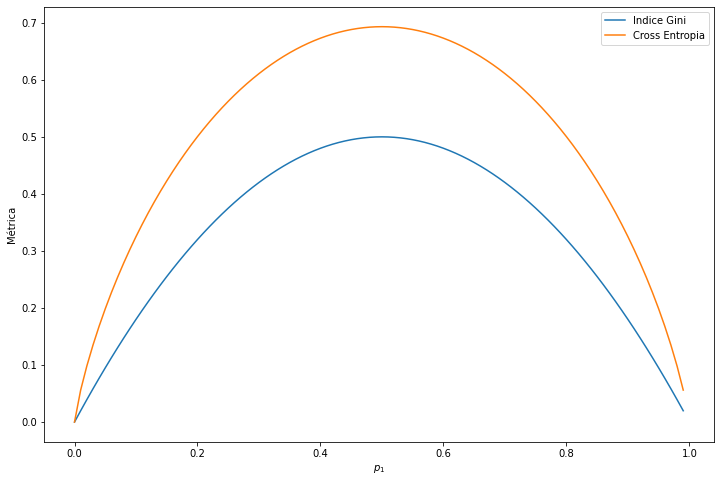

In [4]:
fig = plt.figure(figsize=(12,8))
p = np.arange(0+1e-15,1+1e-15,0.01)
plt.plot(p, 2*p*(1-p), label='Indice Gini')
plt.plot(p, -(p*np.log(p) + (1-p)*np.log(1-p)) , label='Cross Entropia')
plt.legend();
plt.xlabel('$p_{1}$');
plt.ylabel('Métrica');

## Principais Parâmetros

- criterion: função utilizada para medir qualidade do split. Para regressão o default é mse, para classficação é o gini. 
- max_depth: profundidade máxima das árvores
- min_samples_split: limita o crescimento da árvore, requer número mínimo de registros para quebra de nó
- min_samples_leaf: limita o crescimento da árvore, requer número mínimo de registros para os nó terminais (folhas) 
- ccp_alpha : parametro do cost-complexity prunning

### Pros e Contras

**Vantagens**
- Capazes de capturar relações não lineares com alta interpretabilidade (não paramétrico) - considerado um "white box" - com decisões simples
- Não é necessário normalizar os dados, pois cada split considera apenas uma dimensão por step de quebra
- Lidam com categoricas sem precisar dummizar
- Pode-se visualizar as variáveis que proporcionar maior ganho de informação e se determinar a feature importance dos preditores
- Podem ser utilizadas tanto para regressão como para classificação
- Possíveis de ser representadas graficamente, podendo gerar insight negócio, sendo que a lógica utilizada para classificar é maior próximo de um "olhar humano"
- É naturalmente um algoritmo multiclass (não é necessário fazer adaptações)
- O custo de predição é logarítmico em relação ao número de registros utilizados no treino

**Desvantagens**
- Podem ser tendenciosas a ter overfitting, caso não tenha devido prunning - onde passa a ser importante se justar a profundidade máxima e o número de mínimo de registros por folha 
- São greedy (gulosa) , consideram localmente divisões sem considerar os próximos splits
- Podem ser instáveis : pequenas variações no conjunto de treino proporcionam arvores bem diferentes (problema normalmente contornado pelo uso de ensemble)
- As previsões não são normalmente contínuas nem smooth (quebras exatas)
- Encontrar árvores é considerado um "NP problem" -  o que faz aplicar heurísitica como a busca greedy por parâmetros adequado de quebras (o que não garante uma resposta global)
- É impactado pelo desbalanceamento de classes
- Performance costuma ser inferior quando comparado com modelos mais potentes (boosting, bagging, SVC)

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

Hierarchy of if/else questions >>>> final decision
Tree has no ability to generate new responses, outside of what seen in the training data
Control complexity: pre-prunning parameters (max_depth, max_leaf_nodes, min_samples_leaf)
Resulting model easily visualized
There is no need of scaling of the data(invariant)
Tend to overfit and provide poor generalization
The algorithm searches over all possible tests and finds the one that is most informative about the target variable

# Introduction

In [5]:
# Back to iris dataset
from sklearn.datasets import load_iris

iris=load_iris()
X=pd.DataFrame(iris.data, columns= iris.feature_names)
y=pd.Series(iris.target)

In [6]:
from typing import List
from itertools import combinations

def gini(y):
    gini=0
    for y_i in np.unique(y):
        p = (y==y_i).mean()
        gini+=p*(1-p)
    return gini

gini(y)

0.6666666666666667

In [7]:
def entropy(y):
    s=0
    for y_i in np.unique(y):
        p = (y==y_i).mean()
        s+=-p*np.log2(p)
    return s

entropy(y)

1.584962500721156

In [8]:
class Tree():
    
    def __init__(self,criterion='gini'):
        self.criterion = criterion
        
    def fit(self, X,y):
        self.X = X
        self.y = y
        self.nodes = {}
        self.counter = 0

    def find_best_split_feature(self, coluna, X, y):
        if (self.criterion=='gini'):
            
            IG_best=-1
            s_best= None
            
            gini_before_split = gini(y)
            n_tot = y.shape[0]
            
            for s in np.sort(X[coluna].unique()):
                left = y[X[coluna]<s]
                right = y[X[coluna]>=s]
                n_left = left.shape[0]
                n_right = right.shape[0]
                IG = gini_before_split - ((n_left/n_tot)*(gini(left)) + (n_right/n_tot)*(gini(right))) 
                
                if IG > IG_best:
                    IG_best = IG
                    s_best = s
#                     print('Econtrado um melhor split em {} em {} no valor de {}'.format(coluna, s, IG))
            
            return s_best, IG_best 
        
    def find_best_split(self, X,y):
            
        gains = {}
            
        for coluna in self.X.columns:
                
            gains[coluna] = self.find_best_split_feature(coluna, X,y)    
                
        return gains
    
    def create_tree(self, X,y, mins_samples=10):
    
    # Ainda não funciona muito bem!!! revisar
    
        bests_ = self.find_best_split(X,y)
        n_samples = X.shape[0]
        
        print(y.unique())
        if ((n_samples < mins_samples) | len(y.unique())==1):
            print('finalizado')
            return
        
        
        #  melhor variavel (iterando no dicionario)
        best_variable = max(bests_.items(), key=lambda i : i[1][1])[0]
        best_split = max(bests_.items(), key=lambda i : i[1][1])[1][0]
        IG = max(bests_.items(), key=lambda i : i[1][1])[1][1]
        
#         self.splits[str(best_variable)+'_'str(best_split)] = (best_variable, best_split, IG)
        
        print('split {} no valor {}'.format(best_variable, best_split))
        
        left = X[best_variable]<best_split
        X_left = X[left]
        y_left = y[left]
        
        right = X[best_variable]>=best_split
        X_right = X[right]
        y_right = y[right]
        
        i = str(self.counter)
        self.nodes[(best_variable,best_split)], self.nodes[(best_variable,best_split)] = ((best_variable, best_split, IG, 'left'),(best_variable, best_split, IG, 'right'))
        self.counter = self.counter +1
        self.create_tree(X_left, y_left),self.create_tree(X_right, y_right)
        
a = Tree('gini')
a.fit(X,y)
a.create_tree(X,y)

[0 1 2]
split petal length (cm) no valor 3.0
[0]
finalizado
[1 2]
split petal width (cm) no valor 1.8
[1 2]
split petal length (cm) no valor 5.0
[1 2]
split petal width (cm) no valor 1.7
[1]
finalizado
[2]
finalizado
[1 2]
split petal width (cm) no valor 1.6
[2]
finalizado
[1 2]
split sepal length (cm) no valor 7.2
[1]
finalizado
[2]
finalizado
[1 2]
split petal length (cm) no valor 4.9
[1 2]
split sepal length (cm) no valor 6.0
[1]
finalizado
[2]
finalizado
[2]
finalizado


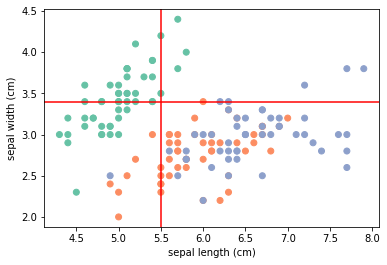

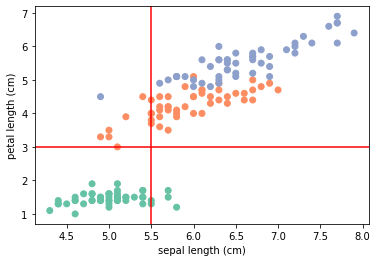

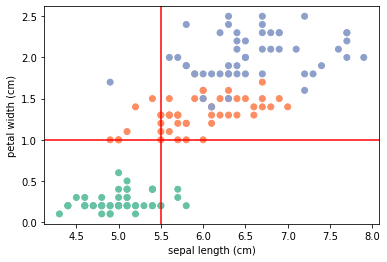

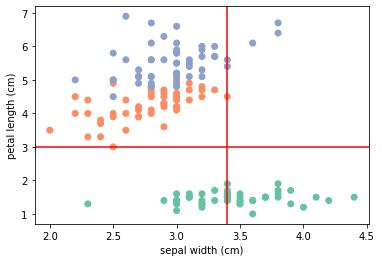

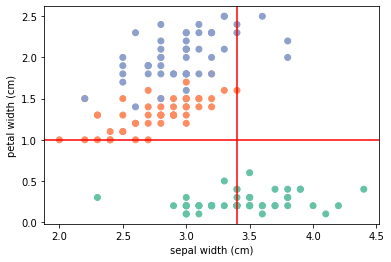

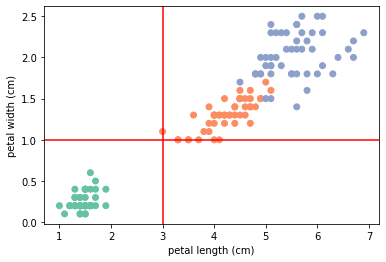

In [92]:
import itertools
import seaborn as sns

rgb_values = sns.color_palette("Set2", 3)
colors = dict(zip(y.unique(), rgb_values))
c_ = [colors[y_i] for y_i in y]

for combination in list(itertools.combinations(X.columns, 2)):
    plt.scatter(X[combination[0]],X[combination[1]],c = c_)
    plt.xlabel(combination[0])
    plt.ylabel(combination[1])
    plt.axvline(x=best_splits[combination[0]][0], color='r', linestyle='-')
    plt.axhline(y=best_splits[combination[1]][0], color='r', linestyle='-')

    plt.show()
    
    

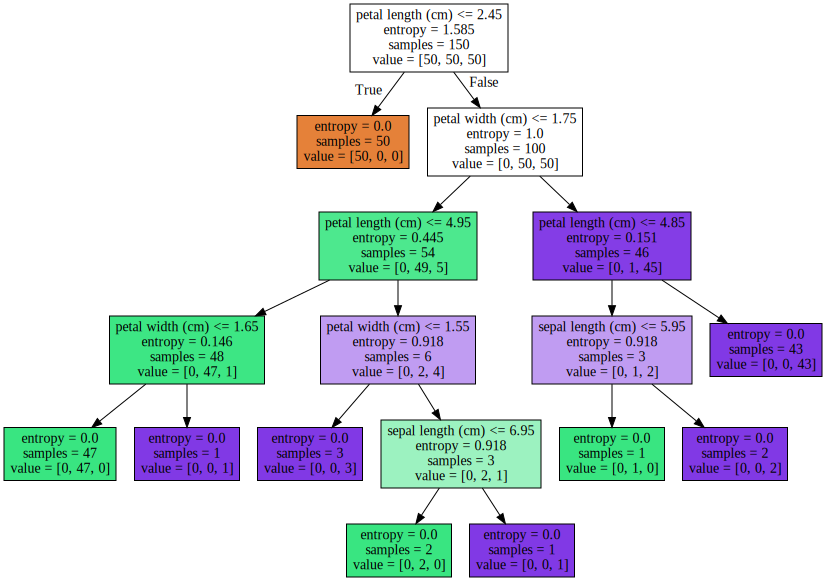

In [75]:
from sklearn.tree import export_graphviz
import graphviz

def plot_tree(classifier,X,y):
    classifier= DecisionTreeClassifier(criterion='entropy')
    classifier.fit(X, y)
    y_pred = classifier.predict(X)

    export_graphviz(classifier, feature_names = X.columns, out_file='tree.dot',impurity=True, filled=True)

    with open('tree.dot') as f:
        dot_graph=f.read()
    display(graphviz.Source(dot_graph))
    
plot_tree(classifier,X,y)

In [13]:
# --- considering only one feature ---

def eval_split(X,y,col, splt_val, metr):
    
    idl = X[col]<=splt_val
    idr = X[col]>splt_val
    
    X_l, y_l, X_r, y_r = X[idl], y[idl], X[idr], y[idr]
    
    Pr_l = X_l.shape[0]/X.shape[0]
    Pr_r = X_r.shape[0]/X.shape[0]
    
    G_i = metr(y)
    G_f= Pr_l*metr(y_l) + Pr_r*metr(y_r)
    
    return G_i - G_f
    

In [14]:
eval_split(X,y,X.columns[0],7, entropy)

0.1371657637407655

---iteration: 1 : gain: 0.004, best split:4.300, dimension split:sepal length (cm)
---iteration: 3 : gain: 0.018, best split:4.500, dimension split:sepal length (cm)
---iteration: 4 : gain: 0.023, best split:4.600, dimension split:sepal length (cm)
---iteration: 5 : gain: 0.043, best split:4.700, dimension split:sepal length (cm)
---iteration: 6 : gain: 0.053, best split:4.800, dimension split:sepal length (cm)
---iteration: 7 : gain: 0.080, best split:4.900, dimension split:sepal length (cm)
---iteration: 8 : gain: 0.085, best split:5.000, dimension split:sepal length (cm)
---iteration: 9 : gain: 0.120, best split:5.100, dimension split:sepal length (cm)
---iteration: 10 : gain: 0.168, best split:5.200, dimension split:sepal length (cm)
---iteration: 11 : gain: 0.185, best split:5.300, dimension split:sepal length (cm)
---iteration: 12 : gain: 0.192, best split:5.400, dimension split:sepal length (cm)
---iteration: 13 : gain: 0.228, best split:5.500, dimension split:sepal length (cm)


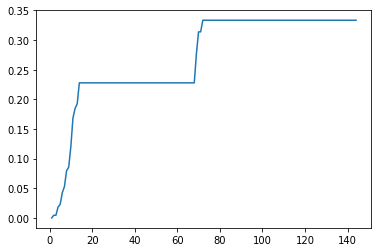

In [15]:
def return_best_split(X,y):
    g={}
    g_max=0
    id=0
    count=0

    for col in X.columns:
        for i in np.arange(min(X[col]),max(X[col]),0.1):
    #         print(col)
            count=count+1
            gain = eval_split(X,y,col,i, gini)
            g[count]=g_max
            
            if(gain>g_max):
                col_esc=col
                g_max=gain
                id=i
                print('---iteration: {} : gain: {:.3f}, best split:{:.3f}, dimension split:{}'.format(count,gain,i, col))
    
    
    print('max gain: {:.2f} split on X{}: {:.2f}\n'.format(g_max,col_esc, id))
    return g,g_max
    
    
gs, gmax= return_best_split(X,y)
plt.plot(gs.keys(), gs.values());

(1.5, 5.0)

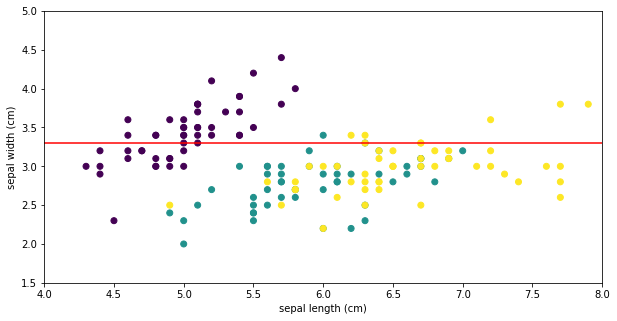

In [16]:
fig= plt.figure(figsize=(10,5))

plt.scatter(X.iloc[:,0], X.iloc[:,1], c= y);
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])

line=np.arange(0,10)
plt.plot(line, np.ones(len(line))*3.3, c='r')
plt.xlim(4,8)
plt.ylim(1.5,5)

# Generating a Tree

In [17]:
class Tree:
    def __init__(self):
        self.left = None
        self.right = None
        self.info = None

In [18]:
def trainTree(tree_, X, y, crit):
        
    gain = 0

    for dim in X.columns:
        for datapoint in X[dim]:
            gain_aux = eval_split(X, y, dim, datapoint, crit)

            if gain_aux > gain:
                gain=gain_aux
                bestsplit=datapoint
                dimsplit=dim

            if gain > 0:
    #         if I have gain ---> my split provides less entropy or less gini impurity
                print('gain: {}, best split:{}, dimsplit:{}'.format(gain, bestsplit, dimsplit))
                idl = X[dimsplit]<=bestsplit
                idr = X[dimsplit]>bestsplit
                X_l, X_r, y_l, y_r = X[idl], X[idr], y[idl], y[idr]
                tree_.left = Tree()
                tree_.right = Tree()

                tree_.info = ["nó", dimsplit, datapoint]
                tree_.left = trainTree(tree_.left, X_l, y_l, crit)
                tree_.right = trainTree(tree_.right, X_r, y_r, crit)

            else:
                tree_.info = ["folha", y.value_counts(normalize=True)]

            return tree_


In [19]:
arvore=Tree()
arvore= trainTree(arvore, X, y, gini)

gain: 0.1684194823599613, best split:5.1, dimsplit:sepal length (cm)
gain: 0.08255912567718926, best split:5.4, dimsplit:sepal length (cm)
gain: 0.06286963765097875, best split:5.8, dimsplit:sepal length (cm)
gain: 0.05708655876143559, best split:7.0, dimsplit:sepal length (cm)


In [24]:
arvore.info

['nó', 'sepal length (cm)', 5.1]

# CASE 01 - SOCIAL NETWORKS ADS

In [66]:
dataset=pd.read_csv(r"../Datasets/Social_Network_Ads.csv")

# # Categorical boolean mask
categorical_feature_mask = dataset.dtypes==object

# # filter categorical columns using mask and turn it into a list
categorical_cols = dataset.columns[categorical_feature_mask].tolist()

# # import labelencoder
from sklearn.preprocessing import LabelEncoder

# # instantiate labelencoder object
le = LabelEncoder()

dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col: le.fit_transform(col))

target = 'Purchased'
X=dataset.drop(columns=['User ID',target])
y=dataset[target]

# # # Splitting training and testing
X_train, X_test, y_train, y_test= tts(X,y, test_size=0.25, random_state=0)

In [67]:
classifier= DecisionTreeClassifier(criterion='entropy')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [68]:
print('Training set score:{:.3f}\nTest set score:{:.3f}'.format(classifier.score(X_train, y_train),
                                                                classifier.score(X_test, y_test)))

Training set score:1.000
Test set score:0.910


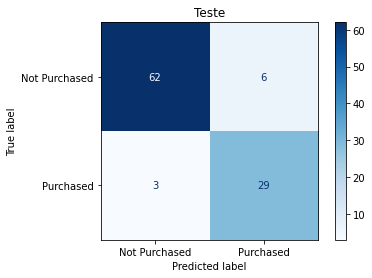

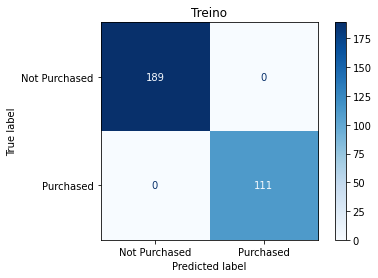

In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Not Purchased','Purchased'], cmap =plt.cm.Blues);
plt.title('Teste');
plot_confusion_matrix(classifier, X_train, y_train, display_labels=['Not Purchased','Purchased'], cmap =plt.cm.Blues);
plt.title('Treino');

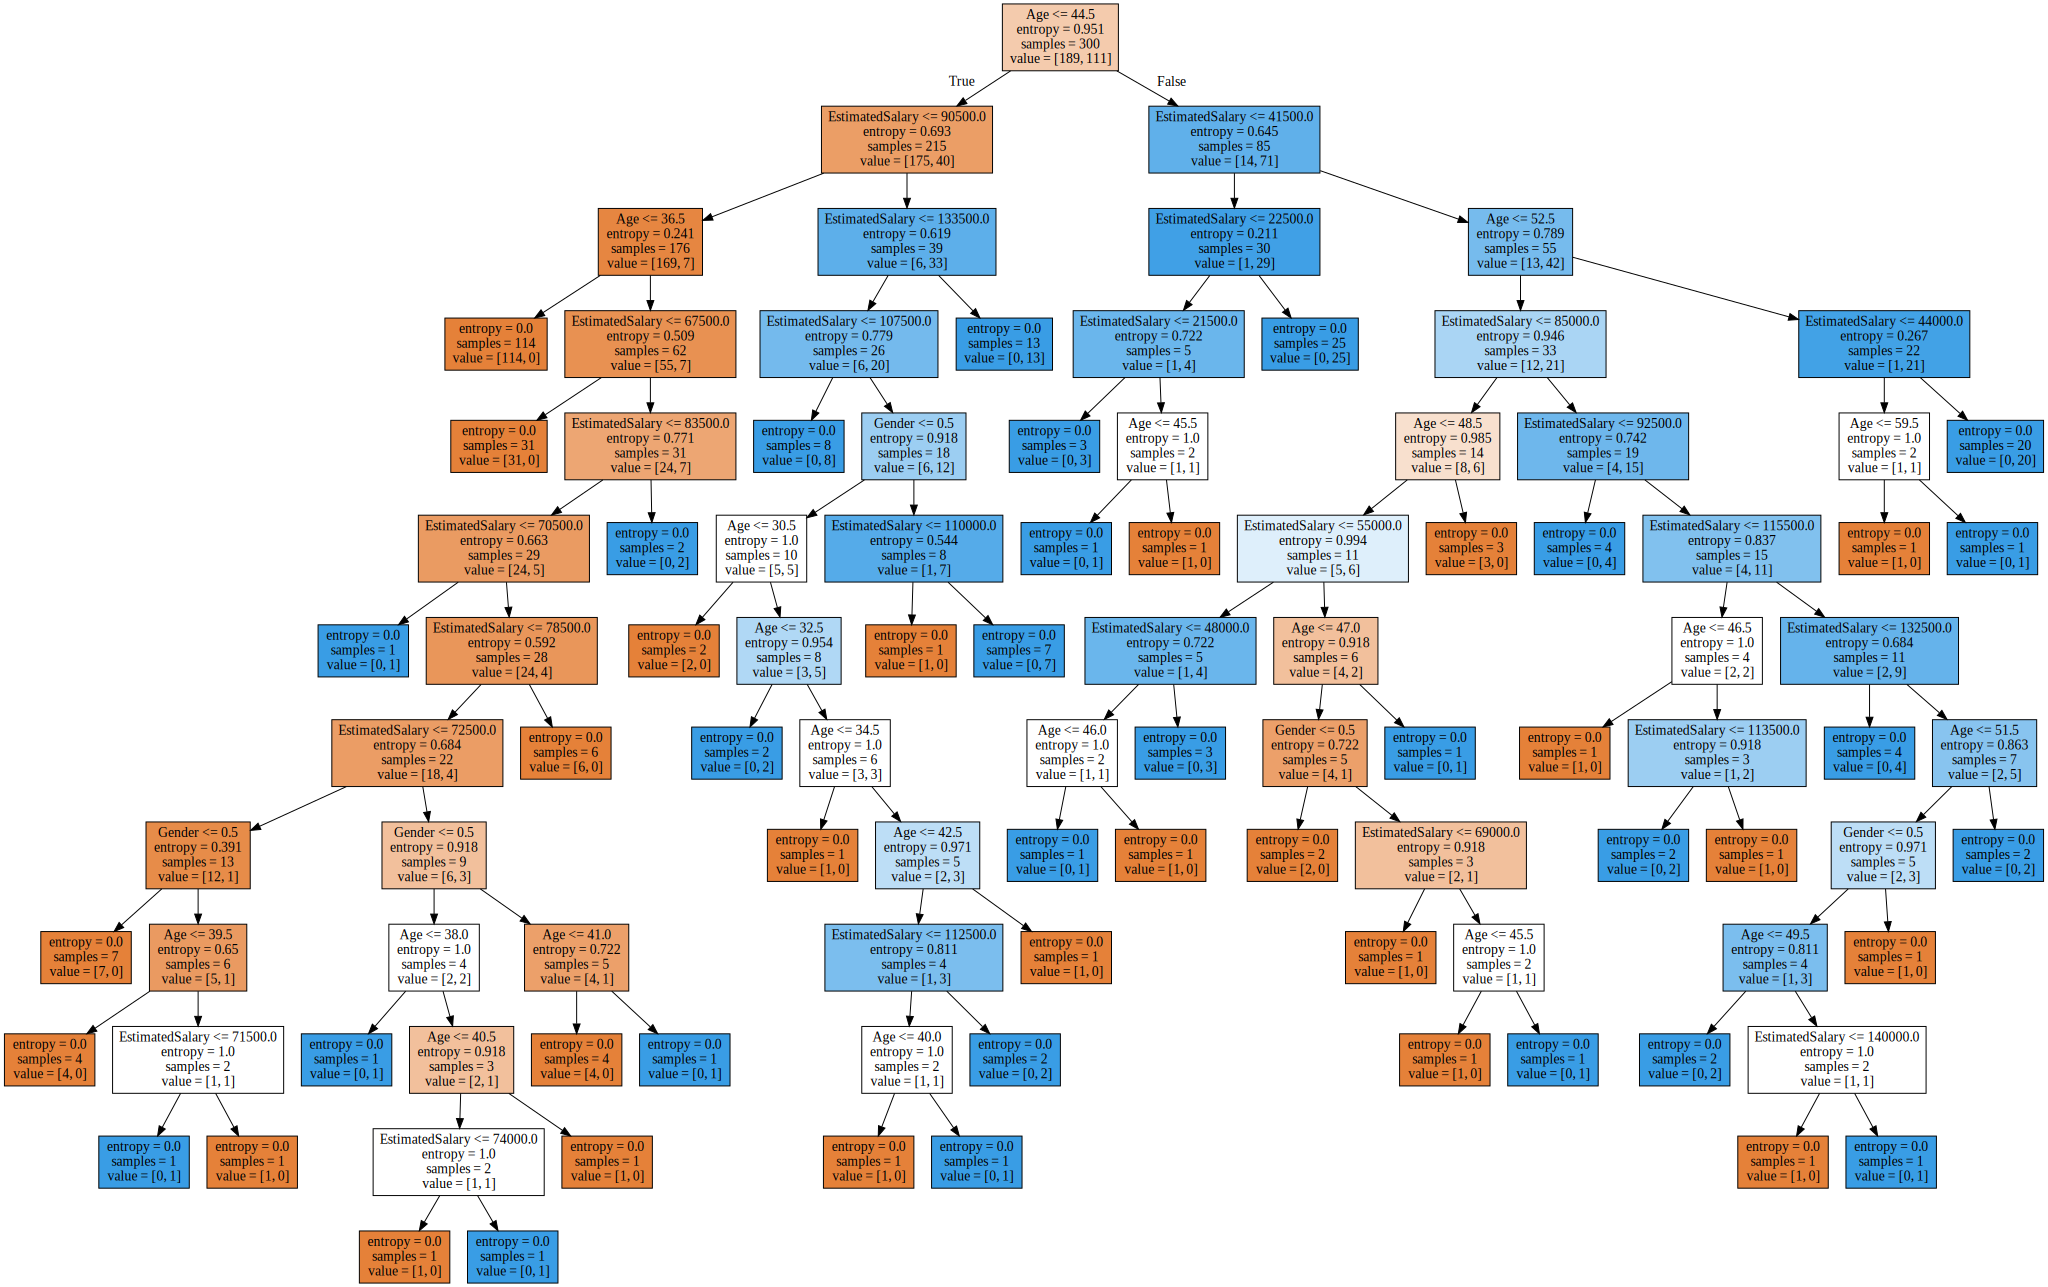

In [85]:
plot_tree(classifier,X_train,y_train)

In [78]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        68
           1       0.83      0.91      0.87        32

    accuracy                           0.91       100
   macro avg       0.89      0.91      0.90       100
weighted avg       0.91      0.91      0.91       100



In [96]:
def plot_decision_function(x1_axis,x2_axis,target, proba=False):

    fig, axis = plt.subplots(1,1, figsize=(20,10))

    X1, X2 = np.meshgrid(np.arange(start= X_train[x1_axis].min() -1, stop= X_train[x1_axis].max() +1, step = 0.01),
                         np.arange(start= X_train[x2_axis].min()-1, stop= X_train[x2_axis].max() +1, step = 0.01))


    if (proba):
        predictions = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:,1].reshape(X1.shape)
    else:
        predictions = classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)

    # plota no treino
    train = pd.concat([X_train, y_train.reset_index()], axis=1)
    train.plot(x = x1_axis, y =x2_axis, c=target, kind = 'scatter', cmap = 'Spectral', s=100, alpha =0.6, ax=axis)
    axis.contourf(X1,X2, predictions, cmap = 'Spectral', alpha = 0.2)
    axis.set_title('Superfície de Decisão - Treino')
    plt.show()
    
    # plota no teste
    fig, axis = plt.subplots(1,1, figsize=(20,10))

    test = pd.concat([X_test, y_test.reset_index()], axis=1)
    test.plot(x = x1_axis, y =x2_axis, c=target, kind = 'scatter', cmap = 'Spectral', s=100, alpha =0.6, ax=axis)
    axis.contourf(X1,X2, predictions, cmap = 'Spectral', alpha = 0.2)
    axis.set_title('Superfície de Decisão - Teste')
    plt.show()
    

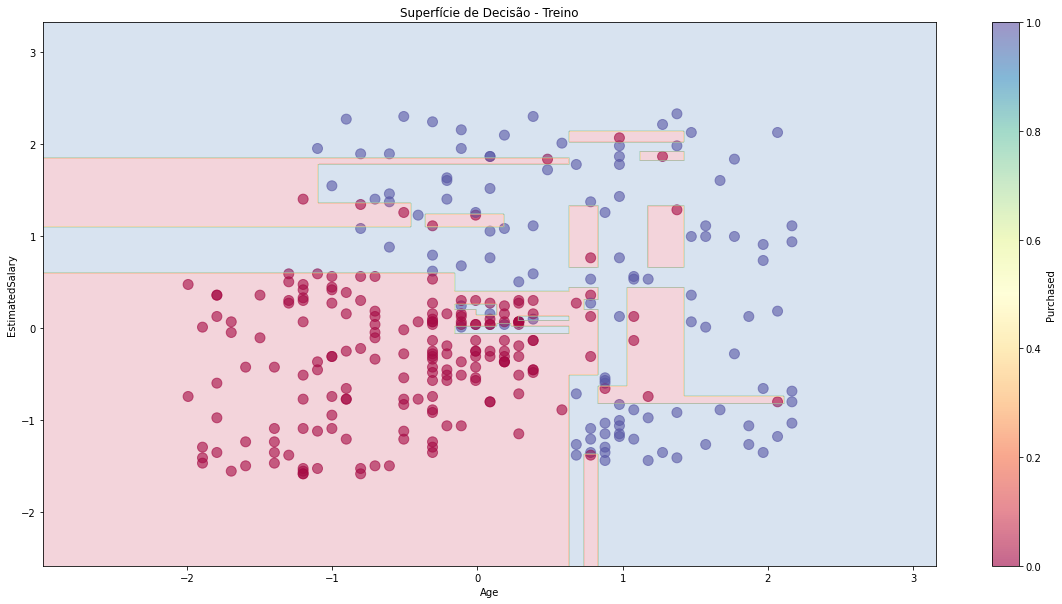

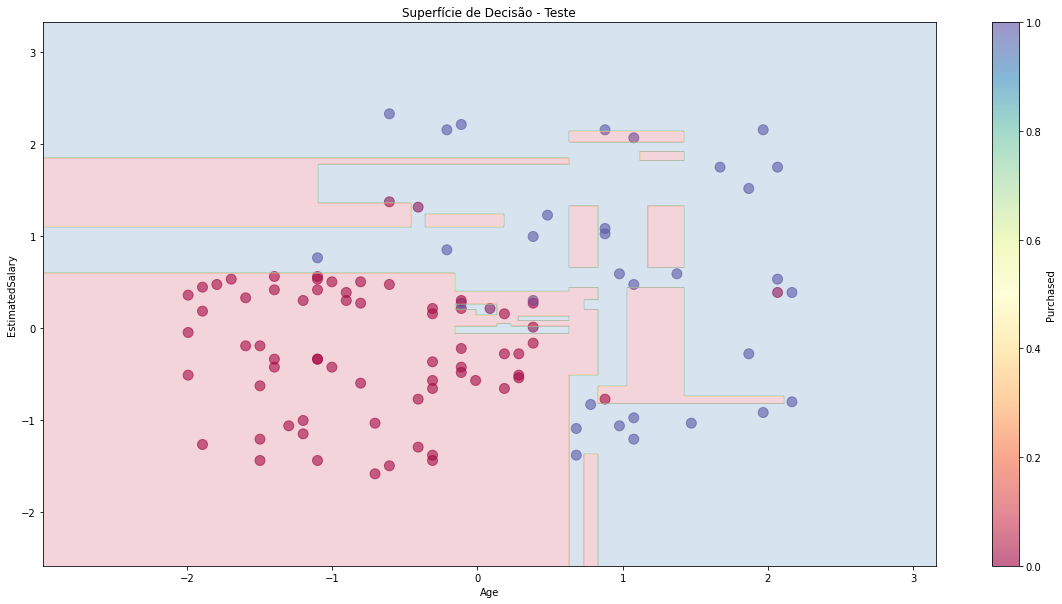

In [101]:
x1_axis = 'Age'
x2_axis= 'EstimatedSalary'
target = 'Purchased'

# Usando somente dois features
target = 'Purchased'
X=dataset[[x1_axis,x2_axis]]
y=dataset[target]

# # # Splitting training and testing
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.25, random_state=0)

from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

# classifier= DecisionTreeClassifier(max_depth=3,criterion='entropy')
classifier= DecisionTreeClassifier(criterion='entropy')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

plot_decision_function(x1_axis,x2_axis,target, proba=True)

# CASE 02 - BREAST CANCER (SKLEARN DATASET) ANALYSIS

In [103]:
cancer= load_breast_cancer()

X_train, X_test, y_train, y_test= train_test_split(cancer.data,cancer.target,stratify=cancer.target, random_state=42)

tree = DecisionTreeClassifier(random_state=0)

tree.fit(X_train, y_train)

print('Training set score:{:.3f}\nTest set score:{:.3f}'.format(tree.score(X_train, y_train),tree.score(X_test, y_test)))

Training set score:1.000
Test set score:0.937


In [113]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

Training set score:1.000
Test set score:0.937


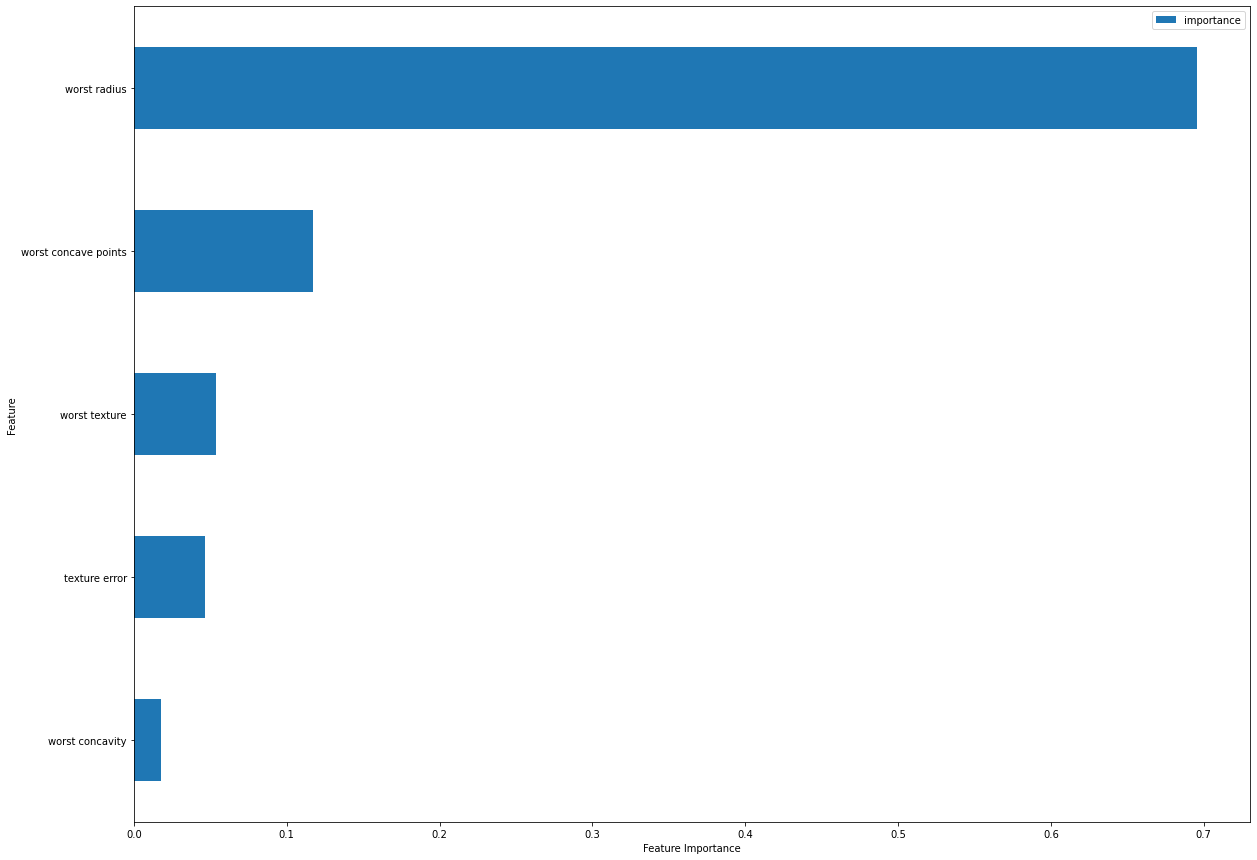

In [124]:
def plot_feature_imp_cancer(model):
    fig, axis = plt.subplots(1,1, figsize=(20,15))
    df_feat_imp = (pd.DataFrame({'feature':cancer.feature_names, 
                                'importance':model.feature_importances_})
                   .set_index('feature')
                   .sort_values(by='importance', ascending=False)
                   .head()
                   .sort_values(by='importance', ascending=True)
                   .plot(kind='barh',ax=axis))
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    
plot_feature_imp_cancer(tree);

print('Training set score:{:.3f}\nTest set score:{:.3f}'.format(tree.score(X_train, y_train),tree.score(X_test, y_test)))